
# Projet - Real or Not? NLP with Disaster Tweets

## Project description 

* Competition - https://www.kaggle.com/c/nlp-getting-started



    Twitter has become an important communication channel in times of emergency.
    The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).
    Our challenge is to build a machine learning model that predicts which Tweets are about real disasters and which one aren’t. We have access to a dataset of 7613 tweets that were hand classified. 
    We will try two differents neural networks: one with GRU Layers and one with pretrained embedding using tensorflow hub
---



# Preprocessing

In [127]:
!pip install plotly -q
!pip install spacy -q
!spacy download en_core_web_sm -q
!pip install tensorflow-hub -q

     |████████████████████████████████| 12.0 MB 4.0 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [128]:
import re
import pandas as pd
import numpy as np
from itertools import product
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
import ast

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Embedding, GRU
from tensorflow.keras.layers import Dropout, Activation
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D 
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import tensorflow_hub as hub

import warnings
warnings.filterwarnings('ignore')

In [129]:
df = pd.read_csv("train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [130]:
print(df.shape)
df.describe(include="all")

(7613, 5)


,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [131]:
df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

### we can see from the description above that the target is balanced, with 43 % on disaster tweets
### So our baseline score that we will use as a reference will be 43% of accuracy.

### We keep only the column that have no nan, ie id, text, and target

In [132]:
df = df[["id","text","target"]]
# After spending time analysing the dataset, we found duplicates, let's drop them
df = df.drop_duplicates(['text'])

In [133]:
# Let's look at our some exmples with the two values of the target
print(df[df["target"] == 0]["text"].values[460])
print()
print(df[df["target"] == 1]["text"].values[340])

they say bad things happen for a reason
but no wise words gonna stop te bleeding

Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power


### We'll use NLP preprocessing methods to set the texts ready for the NLP analysis

In [134]:
# Let's create a clean function that replace a lot of misspelling, contractions, encoded characters by the correct string
# I found this cleaning function in a Kaggle notebook that use the regular expression operation sub replace a part of the tweet
def clean(tweet): 
            
    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
            
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)   
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
    # Hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"aRmageddon", "armageddon", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet)
    tweet = re.sub(r"Hostage&2", "Hostage & 2", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
    tweet = re.sub(r"DETECTADO", "Detected", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"NickCannon", "Nick Cannon", tweet)
    tweet = re.sub(r"FaroeIslands", "Faroe Islands", tweet)
    tweet = re.sub(r"yycstorm", "Calgary Storm", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
    tweet = re.sub(r"UTC2015", "UTC 2015", tweet)
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"OBLITERATION", "obliteration", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"megynkelly", "Megyn Kelly", tweet)
    tweet = re.sub(r"cnewslive", "C News Live", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"cjoyner", "Chris Joyner", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"S3XLEAK", "sex leak", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"foodscare", "food scare", tweet)
    tweet = re.sub(r"MNPDNashville", "Metropolitan Nashville Police Department", tweet)
    tweet = re.sub(r"TfLBusAlerts", "TfL Bus Alerts", tweet)
    tweet = re.sub(r"GamerGate", "Gamer Gate", tweet)
    tweet = re.sub(r"IHHen", "Humanitarian Relief", tweet)
    tweet = re.sub(r"spinningbot", "spinning bot", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"po_st", "po.st", tweet)
    tweet = re.sub(r"scoopit", "scoop.it", tweet)
    tweet = re.sub(r"UltimaLucha", "Ultima Lucha", tweet)
    tweet = re.sub(r"JonathanFerrell", "Jonathan Ferrell", tweet)
    tweet = re.sub(r"aria_ahrary", "Aria Ahrary", tweet)
    tweet = re.sub(r"rapidcity", "Rapid City", tweet)
    tweet = re.sub(r"OutBid", "outbid", tweet)
    tweet = re.sub(r"lavenderpoetrycafe", "lavender poetry cafe", tweet)
    tweet = re.sub(r"EudryLantiqua", "Eudry Lantiqua", tweet)
    tweet = re.sub(r"15PM", "15 PM", tweet)
    tweet = re.sub(r"OriginalFunko", "Funko", tweet)
    tweet = re.sub(r"rightwaystan", "Richard Tan", tweet)
    tweet = re.sub(r"CindyNoonan", "Cindy Noonan", tweet)
    tweet = re.sub(r"RT_America", "RT America", tweet)
    tweet = re.sub(r"narendramodi", "Narendra Modi", tweet)
    tweet = re.sub(r"BakeOffFriends", "Bake Off Friends", tweet)
    tweet = re.sub(r"TeamHendrick", "Hendrick Motorsports", tweet)
    tweet = re.sub(r"alexbelloli", "Alex Belloli", tweet)
    tweet = re.sub(r"itsjustinstuart", "Justin Stuart", tweet)
    tweet = re.sub(r"gunsense", "gun sense", tweet)
    tweet = re.sub(r"DebateQuestionsWeWantToHear", "debate questions we want to hear", tweet)
    tweet = re.sub(r"RoyalCarribean", "Royal Carribean", tweet)
    tweet = re.sub(r"samanthaturne19", "Samantha Turner", tweet)
    tweet = re.sub(r"JonVoyage", "Jon Stewart", tweet)
    tweet = re.sub(r"renew911health", "renew 911 health", tweet)
    tweet = re.sub(r"SuryaRay", "Surya Ray", tweet)
    tweet = re.sub(r"pattonoswalt", "Patton Oswalt", tweet)
    tweet = re.sub(r"minhazmerchant", "Minhaz Merchant", tweet)
    tweet = re.sub(r"TLVFaces", "Israel Diaspora Coalition", tweet)
    tweet = re.sub(r"pmarca", "Marc Andreessen", tweet)
    tweet = re.sub(r"pdx911", "Portland Police", tweet)
    tweet = re.sub(r"jamaicaplain", "Jamaica Plain", tweet)
    tweet = re.sub(r"Japton", "Arkansas", tweet)
    tweet = re.sub(r"RouteComplex", "Route Complex", tweet)
    tweet = re.sub(r"INSubcontinent", "Indian Subcontinent", tweet)
    tweet = re.sub(r"NJTurnpike", "New Jersey Turnpike", tweet)
    tweet = re.sub(r"Politifiact", "PolitiFact", tweet)
    tweet = re.sub(r"Hiroshima70", "Hiroshima", tweet)
    tweet = re.sub(r"GMMBC", "Greater Mt Moriah Baptist Church", tweet)
    tweet = re.sub(r"versethe", "verse the", tweet)
    tweet = re.sub(r"TubeStrike", "Tube Strike", tweet)
    tweet = re.sub(r"MissionHills", "Mission Hills", tweet)
    tweet = re.sub(r"ProtectDenaliWolves", "Protect Denali Wolves", tweet)
    tweet = re.sub(r"NANKANA", "Nankana", tweet)
    tweet = re.sub(r"SAHIB", "Sahib", tweet)
    tweet = re.sub(r"PAKPATTAN", "Pakpattan", tweet)
    tweet = re.sub(r"Newz_Sacramento", "News Sacramento", tweet)
    tweet = re.sub(r"gofundme", "go fund me", tweet)
    tweet = re.sub(r"pmharper", "Stephen Harper", tweet)
    tweet = re.sub(r"IvanBerroa", "Ivan Berroa", tweet)
    tweet = re.sub(r"LosDelSonido", "Los Del Sonido", tweet)
    tweet = re.sub(r"bancodeseries", "banco de series", tweet)
    tweet = re.sub(r"timkaine", "Tim Kaine", tweet)
    tweet = re.sub(r"IdentityTheft", "Identity Theft", tweet)
    tweet = re.sub(r"AllLivesMatter", "All Lives Matter", tweet)
    tweet = re.sub(r"mishacollins", "Misha Collins", tweet)
    tweet = re.sub(r"BillNeelyNBC", "Bill Neely", tweet)
    tweet = re.sub(r"BeClearOnCancer", "be clear on cancer", tweet)
    tweet = re.sub(r"Kowing", "Knowing", tweet)
    tweet = re.sub(r"ScreamQueens", "Scream Queens", tweet)
    tweet = re.sub(r"AskCharley", "Ask Charley", tweet)
    tweet = re.sub(r"BlizzHeroes", "Heroes of the Storm", tweet)
    tweet = re.sub(r"BradleyBrad47", "Bradley Brad", tweet)
    tweet = re.sub(r"HannaPH", "Typhoon Hanna", tweet)
    tweet = re.sub(r"meinlcymbals", "MEINL Cymbals", tweet)
    tweet = re.sub(r"Ptbo", "Peterborough", tweet)
    tweet = re.sub(r"cnnbrk", "CNN Breaking News", tweet)
    tweet = re.sub(r"IndianNews", "Indian News", tweet)
    tweet = re.sub(r"savebees", "save bees", tweet)
    tweet = re.sub(r"GreenHarvard", "Green Harvard", tweet)
    tweet = re.sub(r"StandwithPP", "Stand with planned parenthood", tweet)
    tweet = re.sub(r"hermancranston", "Herman Cranston", tweet)
    tweet = re.sub(r"WMUR9", "WMUR-TV", tweet)
    tweet = re.sub(r"RockBottomRadFM", "Rock Bottom Radio", tweet)
    tweet = re.sub(r"ameenshaikh3", "Ameen Shaikh", tweet)
    tweet = re.sub(r"ProSyn", "Project Syndicate", tweet)
    tweet = re.sub(r"Daesh", "ISIS", tweet)
    tweet = re.sub(r"s2g", "swear to god", tweet)
    tweet = re.sub(r"listenlive", "listen live", tweet)
    tweet = re.sub(r"CDCgov", "Centers for Disease Control and Prevention", tweet)
    tweet = re.sub(r"FoxNew", "Fox News", tweet)
    tweet = re.sub(r"CBSBigBrother", "Big Brother", tweet)
    tweet = re.sub(r"JulieDiCaro", "Julie DiCaro", tweet)
    tweet = re.sub(r"theadvocatemag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"RohnertParkDPS", "Rohnert Park Police Department", tweet)
    tweet = re.sub(r"THISIZBWRIGHT", "Bonnie Wright", tweet)
    tweet = re.sub(r"Popularmmos", "Popular MMOs", tweet)
    tweet = re.sub(r"WildHorses", "Wild Horses", tweet)
    tweet = re.sub(r"FantasticFour", "Fantastic Four", tweet)
    tweet = re.sub(r"HORNDALE", "Horndale", tweet)
    tweet = re.sub(r"PINER", "Piner", tweet)
    tweet = re.sub(r"BathAndNorthEastSomerset", "Bath and North East Somerset", tweet)
    tweet = re.sub(r"thatswhatfriendsarefor", "that is what friends are for", tweet)
    tweet = re.sub(r"residualincome", "residual income", tweet)
    tweet = re.sub(r"YahooNewsDigest", "Yahoo News Digest", tweet)
    tweet = re.sub(r"MalaysiaAirlines", "Malaysia Airlines", tweet)
    tweet = re.sub(r"AmazonDeals", "Amazon Deals", tweet)
    tweet = re.sub(r"MissCharleyWebb", "Charley Webb", tweet)
    tweet = re.sub(r"shoalstraffic", "shoals traffic", tweet)
    tweet = re.sub(r"GeorgeFoster72", "George Foster", tweet)
    tweet = re.sub(r"pop2015", "pop 2015", tweet)
    tweet = re.sub(r"_PokemonCards_", "Pokemon Cards", tweet)
    tweet = re.sub(r"DianneG", "Dianne Gallagher", tweet)
    tweet = re.sub(r"KashmirConflict", "Kashmir Conflict", tweet)
    tweet = re.sub(r"BritishBakeOff", "British Bake Off", tweet)
    tweet = re.sub(r"FreeKashmir", "Free Kashmir", tweet)
    tweet = re.sub(r"mattmosley", "Matt Mosley", tweet)
    tweet = re.sub(r"BishopFred", "Bishop Fred", tweet)
    tweet = re.sub(r"EndConflict", "End Conflict", tweet)
    tweet = re.sub(r"EndOccupation", "End Occupation", tweet)
    tweet = re.sub(r"UNHEALED", "unhealed", tweet)
    tweet = re.sub(r"CharlesDagnall", "Charles Dagnall", tweet)
    tweet = re.sub(r"Latestnews", "Latest news", tweet)
    tweet = re.sub(r"KindleCountdown", "Kindle Countdown", tweet)
    tweet = re.sub(r"NoMoreHandouts", "No More Handouts", tweet)
    tweet = re.sub(r"datingtips", "dating tips", tweet)
    tweet = re.sub(r"charlesadler", "Charles Adler", tweet)
    tweet = re.sub(r"twia", "Texas Windstorm Insurance Association", tweet)
    tweet = re.sub(r"txlege", "Texas Legislature", tweet)
    tweet = re.sub(r"WindstormInsurer", "Windstorm Insurer", tweet)
    tweet = re.sub(r"Newss", "News", tweet)
    tweet = re.sub(r"hempoil", "hemp oil", tweet)
    tweet = re.sub(r"CommoditiesAre", "Commodities are", tweet)
    tweet = re.sub(r"tubestrike", "tube strike", tweet)
    tweet = re.sub(r"JoeNBC", "Joe Scarborough", tweet)
    tweet = re.sub(r"LiteraryCakes", "Literary Cakes", tweet)
    tweet = re.sub(r"TI5", "The International 5", tweet)
    tweet = re.sub(r"thehill", "the hill", tweet)
    tweet = re.sub(r"3others", "3 others", tweet)
    tweet = re.sub(r"stighefootball", "Sam Tighe", tweet)
    tweet = re.sub(r"whatstheimportantvideo", "what is the important video", tweet)
    tweet = re.sub(r"ClaudioMeloni", "Claudio Meloni", tweet)
    tweet = re.sub(r"DukeSkywalker", "Duke Skywalker", tweet)
    tweet = re.sub(r"carsonmwr", "Fort Carson", tweet)
    tweet = re.sub(r"offdishduty", "off dish duty", tweet)
    tweet = re.sub(r"andword", "and word", tweet)
    tweet = re.sub(r"rhodeisland", "Rhode Island", tweet)
    tweet = re.sub(r"easternoregon", "Eastern Oregon", tweet)
    tweet = re.sub(r"WAwildfire", "Washington Wildfire", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"57am", "57 am", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"JacobHoggard", "Jacob Hoggard", tweet)
    tweet = re.sub(r"newnewnew", "new new new", tweet)
    tweet = re.sub(r"under50", "under 50", tweet)
    tweet = re.sub(r"getitbeforeitsgone", "get it before it is gone", tweet)
    tweet = re.sub(r"freshoutofthebox", "fresh out of the box", tweet)
    tweet = re.sub(r"amwriting", "am writing", tweet)
    tweet = re.sub(r"Bokoharm", "Boko Haram", tweet)
    tweet = re.sub(r"Nowlike", "Now like", tweet)
    tweet = re.sub(r"seasonfrom", "season from", tweet)
    tweet = re.sub(r"epicente", "epicenter", tweet)
    tweet = re.sub(r"epicenterr", "epicenter", tweet)
    tweet = re.sub(r"sicklife", "sick life", tweet)
    tweet = re.sub(r"yycweather", "Calgary Weather", tweet)
    tweet = re.sub(r"calgarysun", "Calgary Sun", tweet)
    tweet = re.sub(r"approachng", "approaching", tweet)
    tweet = re.sub(r"evng", "evening", tweet)
    tweet = re.sub(r"Sumthng", "something", tweet)
    tweet = re.sub(r"EllenPompeo", "Ellen Pompeo", tweet)
    tweet = re.sub(r"shondarhimes", "Shonda Rhimes", tweet)
    tweet = re.sub(r"ABCNetwork", "ABC Network", tweet)
    tweet = re.sub(r"SushmaSwaraj", "Sushma Swaraj", tweet)
    tweet = re.sub(r"pray4japan", "Pray for Japan", tweet)
    tweet = re.sub(r"hope4japan", "Hope for Japan", tweet)
    tweet = re.sub(r"Illusionimagess", "Illusion images", tweet)
    tweet = re.sub(r"SummerUnderTheStars", "Summer Under The Stars", tweet)
    tweet = re.sub(r"ShallWeDance", "Shall We Dance", tweet)
    tweet = re.sub(r"TCMParty", "TCM Party", tweet)
    tweet = re.sub(r"marijuananews", "marijuana news", tweet)
    tweet = re.sub(r"onbeingwithKristaTippett", "on being with Krista Tippett", tweet)
    tweet = re.sub(r"Beingtweets", "Being tweets", tweet)
    tweet = re.sub(r"newauthors", "new authors", tweet)
    tweet = re.sub(r"remedyyyy", "remedy", tweet)
    tweet = re.sub(r"44PM", "44 PM", tweet)
    tweet = re.sub(r"HeadlinesApp", "Headlines App", tweet)
    tweet = re.sub(r"40PM", "40 PM", tweet)
    tweet = re.sub(r"myswc", "Severe Weather Center", tweet)
    tweet = re.sub(r"ithats", "that is", tweet)
    tweet = re.sub(r"icouldsitinthismomentforever", "I could sit in this moment forever", tweet)
    tweet = re.sub(r"FatLoss", "Fat Loss", tweet)
    tweet = re.sub(r"02PM", "02 PM", tweet)
    tweet = re.sub(r"MetroFmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"Bstrd", "bastard", tweet)
    tweet = re.sub(r"bldy", "bloody", tweet)
    tweet = re.sub(r"MetrofmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"terrorismturn", "terrorism turn", tweet)
    tweet = re.sub(r"BBCNewsAsia", "BBC News Asia", tweet)
    tweet = re.sub(r"BehindTheScenes", "Behind The Scenes", tweet)
    tweet = re.sub(r"GeorgeTakei", "George Takei", tweet)
    tweet = re.sub(r"WomensWeeklyMag", "Womens Weekly Magazine", tweet)
    tweet = re.sub(r"SurvivorsGuidetoEarth", "Survivors Guide to Earth", tweet)
    tweet = re.sub(r"incubusband", "incubus band", tweet)
    tweet = re.sub(r"Babypicturethis", "Baby picture this", tweet)
    tweet = re.sub(r"BombEffects", "Bomb Effects", tweet)
    tweet = re.sub(r"win10", "Windows 10", tweet)
    tweet = re.sub(r"idkidk", "I do not know I do not know", tweet)
    tweet = re.sub(r"TheWalkingDead", "The Walking Dead", tweet)
    tweet = re.sub(r"amyschumer", "Amy Schumer", tweet)
    tweet = re.sub(r"crewlist", "crew list", tweet)
    tweet = re.sub(r"Erdogans", "Erdogan", tweet)
    tweet = re.sub(r"BBCLive", "BBC Live", tweet)
    tweet = re.sub(r"TonyAbbottMHR", "Tony Abbott", tweet)
    tweet = re.sub(r"paulmyerscough", "Paul Myerscough", tweet)
    tweet = re.sub(r"georgegallagher", "George Gallagher", tweet)
    tweet = re.sub(r"JimmieJohnson", "Jimmie Johnson", tweet)
    tweet = re.sub(r"pctool", "pc tool", tweet)
    tweet = re.sub(r"DoingHashtagsRight", "Doing Hashtags Right", tweet)
    tweet = re.sub(r"ThrowbackThursday", "Throwback Thursday", tweet)
    tweet = re.sub(r"SnowBackSunday", "Snowback Sunday", tweet)
    tweet = re.sub(r"LakeEffect", "Lake Effect", tweet)
    tweet = re.sub(r"RTphotographyUK", "Richard Thomas Photography UK", tweet)
    tweet = re.sub(r"BigBang_CBS", "Big Bang CBS", tweet)
    tweet = re.sub(r"writerslife", "writers life", tweet)
    tweet = re.sub(r"NaturalBirth", "Natural Birth", tweet)
    tweet = re.sub(r"UnusualWords", "Unusual Words", tweet)
    tweet = re.sub(r"wizkhalifa", "Wiz Khalifa", tweet)
    tweet = re.sub(r"acreativedc", "a creative DC", tweet)
    tweet = re.sub(r"vscodc", "vsco DC", tweet)
    tweet = re.sub(r"VSCOcam", "vsco camera", tweet)
    tweet = re.sub(r"TheBEACHDC", "The beach DC", tweet)
    tweet = re.sub(r"buildingmuseum", "building museum", tweet)
    tweet = re.sub(r"WorldOil", "World Oil", tweet)
    tweet = re.sub(r"redwedding", "red wedding", tweet)
    tweet = re.sub(r"AmazingRaceCanada", "Amazing Race Canada", tweet)
    tweet = re.sub(r"WakeUpAmerica", "Wake Up America", tweet)
    tweet = re.sub(r"\\Allahuakbar\\", "Allahu Akbar", tweet)
    tweet = re.sub(r"bleased", "blessed", tweet)
    tweet = re.sub(r"nigeriantribune", "Nigerian Tribune", tweet)
    tweet = re.sub(r"HIDEO_KOJIMA_EN", "Hideo Kojima", tweet)
    tweet = re.sub(r"FusionFestival", "Fusion Festival", tweet)
    tweet = re.sub(r"50Mixed", "50 Mixed", tweet)
    tweet = re.sub(r"NoAgenda", "No Agenda", tweet)
    tweet = re.sub(r"WhiteGenocide", "White Genocide", tweet)
    tweet = re.sub(r"dirtylying", "dirty lying", tweet)
    tweet = re.sub(r"SyrianRefugees", "Syrian Refugees", tweet)
    tweet = re.sub(r"changetheworld", "change the world", tweet)
    tweet = re.sub(r"Ebolacase", "Ebola case", tweet)
    tweet = re.sub(r"mcgtech", "mcg technologies", tweet)
    tweet = re.sub(r"withweapons", "with weapons", tweet)
    tweet = re.sub(r"advancedwarfare", "advanced warfare", tweet)
    tweet = re.sub(r"letsFootball", "let us Football", tweet)
    tweet = re.sub(r"LateNiteMix", "late night mix", tweet)
    tweet = re.sub(r"PhilCollinsFeed", "Phil Collins", tweet)
    tweet = re.sub(r"RudyHavenstein", "Rudy Havenstein", tweet)
    tweet = re.sub(r"22PM", "22 PM", tweet)
    tweet = re.sub(r"54am", "54 AM", tweet)
    tweet = re.sub(r"38am", "38 AM", tweet)
    tweet = re.sub(r"OldFolkExplainStuff", "Old Folk Explain Stuff", tweet)
    tweet = re.sub(r"BlacklivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"InsaneLimits", "Insane Limits", tweet)
    tweet = re.sub(r"youcantsitwithus", "you cannot sit with us", tweet)
    tweet = re.sub(r"2k15", "2015", tweet)
    tweet = re.sub(r"TheIran", "Iran", tweet)
    tweet = re.sub(r"JimmyFallon", "Jimmy Fallon", tweet)
    tweet = re.sub(r"AlbertBrooks", "Albert Brooks", tweet)
    tweet = re.sub(r"defense_news", "defense news", tweet)
    tweet = re.sub(r"nuclearrcSA", "Nuclear Risk Control Self Assessment", tweet)
    tweet = re.sub(r"Auspol", "Australia Politics", tweet)
    tweet = re.sub(r"NuclearPower", "Nuclear Power", tweet)
    tweet = re.sub(r"WhiteTerrorism", "White Terrorism", tweet)
    tweet = re.sub(r"truthfrequencyradio", "Truth Frequency Radio", tweet)
    tweet = re.sub(r"ErasureIsNotEquality", "Erasure is not equality", tweet)
    tweet = re.sub(r"ProBonoNews", "Pro Bono News", tweet)
    tweet = re.sub(r"JakartaPost", "Jakarta Post", tweet)
    tweet = re.sub(r"toopainful", "too painful", tweet)
    tweet = re.sub(r"melindahaunton", "Melinda Haunton", tweet)
    tweet = re.sub(r"NoNukes", "No Nukes", tweet)
    tweet = re.sub(r"curryspcworld", "Currys PC World", tweet)
    tweet = re.sub(r"ineedcake", "I need cake", tweet)
    tweet = re.sub(r"blackforestgateau", "black forest gateau", tweet)
    tweet = re.sub(r"BBCOne", "BBC One", tweet)
    tweet = re.sub(r"AlexxPage", "Alex Page", tweet)
    tweet = re.sub(r"jonathanserrie", "Jonathan Serrie", tweet)
    tweet = re.sub(r"SocialJerkBlog", "Social Jerk Blog", tweet)
    tweet = re.sub(r"ChelseaVPeretti", "Chelsea Peretti", tweet)
    tweet = re.sub(r"irongiant", "iron giant", tweet)
    tweet = re.sub(r"RonFunches", "Ron Funches", tweet)
    tweet = re.sub(r"TimCook", "Tim Cook", tweet)
    tweet = re.sub(r"sebastianstanisaliveandwell", "Sebastian Stan is alive and well", tweet)
    tweet = re.sub(r"Madsummer", "Mad summer", tweet)
    tweet = re.sub(r"NowYouKnow", "Now you know", tweet)
    tweet = re.sub(r"concertphotography", "concert photography", tweet)
    tweet = re.sub(r"TomLandry", "Tom Landry", tweet)
    tweet = re.sub(r"showgirldayoff", "show girl day off", tweet)
    tweet = re.sub(r"Yougslavia", "Yugoslavia", tweet)
    tweet = re.sub(r"QuantumDataInformatics", "Quantum Data Informatics", tweet)
    tweet = re.sub(r"FromTheDesk", "From The Desk", tweet)
    tweet = re.sub(r"TheaterTrial", "Theater Trial", tweet)
    tweet = re.sub(r"CatoInstitute", "Cato Institute", tweet)
    tweet = re.sub(r"EmekaGift", "Emeka Gift", tweet)
    tweet = re.sub(r"LetsBe_Rational", "Let us be rational", tweet)
    tweet = re.sub(r"Cynicalreality", "Cynical reality", tweet)
    tweet = re.sub(r"FredOlsenCruise", "Fred Olsen Cruise", tweet)
    tweet = re.sub(r"NotSorry", "not sorry", tweet)
    tweet = re.sub(r"UseYourWords", "use your words", tweet)
    tweet = re.sub(r"WordoftheDay", "word of the day", tweet)
    tweet = re.sub(r"Dictionarycom", "Dictionary.com", tweet)
    tweet = re.sub(r"TheBrooklynLife", "The Brooklyn Life", tweet)
    tweet = re.sub(r"jokethey", "joke they", tweet)
    tweet = re.sub(r"nflweek1picks", "NFL week 1 picks", tweet)
    tweet = re.sub(r"uiseful", "useful", tweet)
    tweet = re.sub(r"JusticeDotOrg", "The American Association for Justice", tweet)
    tweet = re.sub(r"autoaccidents", "auto accidents", tweet)
    tweet = re.sub(r"SteveGursten", "Steve Gursten", tweet)
    tweet = re.sub(r"MichiganAutoLaw", "Michigan Auto Law", tweet)
    tweet = re.sub(r"birdgang", "bird gang", tweet)
    tweet = re.sub(r"nflnetwork", "NFL Network", tweet)
    tweet = re.sub(r"NYDNSports", "NY Daily News Sports", tweet)
    tweet = re.sub(r"RVacchianoNYDN", "Ralph Vacchiano NY Daily News", tweet)
    tweet = re.sub(r"EdmontonEsks", "Edmonton Eskimos", tweet)
    tweet = re.sub(r"david_brelsford", "David Brelsford", tweet)
    tweet = re.sub(r"TOI_India", "The Times of India", tweet)
    tweet = re.sub(r"hegot", "he got", tweet)
    tweet = re.sub(r"SkinsOn9", "Skins on 9", tweet)
    tweet = re.sub(r"sothathappened", "so that happened", tweet)
    tweet = re.sub(r"LCOutOfDoors", "LC Out Of Doors", tweet)
    tweet = re.sub(r"NationFirst", "Nation First", tweet)
    tweet = re.sub(r"IndiaToday", "India Today", tweet)
    tweet = re.sub(r"HLPS", "helps", tweet)
    tweet = re.sub(r"HOSTAGESTHROSW", "hostages throw", tweet)
    tweet = re.sub(r"SNCTIONS", "sanctions", tweet)
    tweet = re.sub(r"BidTime", "Bid Time", tweet)
    tweet = re.sub(r"crunchysensible", "crunchy sensible", tweet)
    tweet = re.sub(r"RandomActsOfRomance", "Random acts of romance", tweet)
    tweet = re.sub(r"MomentsAtHill", "Moments at hill", tweet)
    tweet = re.sub(r"eatshit", "eat shit", tweet)
    tweet = re.sub(r"liveleakfun", "live leak fun", tweet)
    tweet = re.sub(r"SahelNews", "Sahel News", tweet)
    tweet = re.sub(r"abc7newsbayarea", "ABC 7 News Bay Area", tweet)
    tweet = re.sub(r"facilitiesmanagement", "facilities management", tweet)
    tweet = re.sub(r"facilitydude", "facility dude", tweet)
    tweet = re.sub(r"CampLogistics", "Camp logistics", tweet)
    tweet = re.sub(r"alaskapublic", "Alaska public", tweet)
    tweet = re.sub(r"MarketResearch", "Market Research", tweet)
    tweet = re.sub(r"AccuracyEsports", "Accuracy Esports", tweet)
    tweet = re.sub(r"TheBodyShopAust", "The Body Shop Australia", tweet)
    tweet = re.sub(r"yychail", "Calgary hail", tweet)
    tweet = re.sub(r"yyctraffic", "Calgary traffic", tweet)
    tweet = re.sub(r"eliotschool", "eliot school", tweet)
    tweet = re.sub(r"TheBrokenCity", "The Broken City", tweet)
    tweet = re.sub(r"OldsFireDept", "Olds Fire Department", tweet)
    tweet = re.sub(r"RiverComplex", "River Complex", tweet)
    tweet = re.sub(r"fieldworksmells", "field work smells", tweet)
    tweet = re.sub(r"IranElection", "Iran Election", tweet)
    tweet = re.sub(r"glowng", "glowing", tweet)
    tweet = re.sub(r"kindlng", "kindling", tweet)
    tweet = re.sub(r"riggd", "rigged", tweet)
    tweet = re.sub(r"slownewsday", "slow news day", tweet)
    tweet = re.sub(r"MyanmarFlood", "Myanmar Flood", tweet)
    tweet = re.sub(r"abc7chicago", "ABC 7 Chicago", tweet)
    tweet = re.sub(r"copolitics", "Colorado Politics", tweet)
    tweet = re.sub(r"AdilGhumro", "Adil Ghumro", tweet)
    tweet = re.sub(r"netbots", "net bots", tweet)
    tweet = re.sub(r"byebyeroad", "bye bye road", tweet)
    tweet = re.sub(r"massiveflooding", "massive flooding", tweet)
    tweet = re.sub(r"EndofUS", "End of United States", tweet)
    tweet = re.sub(r"35PM", "35 PM", tweet)
    tweet = re.sub(r"greektheatrela", "Greek Theatre Los Angeles", tweet)
    tweet = re.sub(r"76mins", "76 minutes", tweet)
    tweet = re.sub(r"publicsafetyfirst", "public safety first", tweet)
    tweet = re.sub(r"livesmatter", "lives matter", tweet)
    tweet = re.sub(r"myhometown", "my hometown", tweet)
    tweet = re.sub(r"tankerfire", "tanker fire", tweet)
    tweet = re.sub(r"MEMORIALDAY", "memorial day", tweet)
    tweet = re.sub(r"MEMORIAL_DAY", "memorial day", tweet)
    tweet = re.sub(r"instaxbooty", "instagram booty", tweet)
    tweet = re.sub(r"Jerusalem_Post", "Jerusalem Post", tweet)
    tweet = re.sub(r"WayneRooney_INA", "Wayne Rooney", tweet)
    tweet = re.sub(r"VirtualReality", "Virtual Reality", tweet)
    tweet = re.sub(r"OculusRift", "Oculus Rift", tweet)
    tweet = re.sub(r"OwenJones84", "Owen Jones", tweet)
    tweet = re.sub(r"jeremycorbyn", "Jeremy Corbyn", tweet)
    tweet = re.sub(r"paulrogers002", "Paul Rogers", tweet)
    tweet = re.sub(r"mortalkombatx", "Mortal Kombat X", tweet)
    tweet = re.sub(r"mortalkombat", "Mortal Kombat", tweet)
    tweet = re.sub(r"FilipeCoelho92", "Filipe Coelho", tweet)
    tweet = re.sub(r"OnlyQuakeNews", "Only Quake News", tweet)
    tweet = re.sub(r"kostumes", "costumes", tweet)
    tweet = re.sub(r"YEEESSSS", "yes", tweet)
    tweet = re.sub(r"ToshikazuKatayama", "Toshikazu Katayama", tweet)
    tweet = re.sub(r"IntlDevelopment", "Intl Development", tweet)
    tweet = re.sub(r"ExtremeWeather", "Extreme Weather", tweet)
    tweet = re.sub(r"WereNotGruberVoters", "We are not gruber voters", tweet)
    tweet = re.sub(r"NewsThousands", "News Thousands", tweet)
    tweet = re.sub(r"EdmundAdamus", "Edmund Adamus", tweet)
    tweet = re.sub(r"EyewitnessWV", "Eye witness WV", tweet)
    tweet = re.sub(r"PhiladelphiaMuseu", "Philadelphia Museum", tweet)
    tweet = re.sub(r"DublinComicCon", "Dublin Comic Con", tweet)
    tweet = re.sub(r"NicholasBrendon", "Nicholas Brendon", tweet)
    tweet = re.sub(r"Alltheway80s", "All the way 80s", tweet)
    tweet = re.sub(r"FromTheField", "From the field", tweet)
    tweet = re.sub(r"NorthIowa", "North Iowa", tweet)
    tweet = re.sub(r"WillowFire", "Willow Fire", tweet)
    tweet = re.sub(r"MadRiverComplex", "Mad River Complex", tweet)
    tweet = re.sub(r"feelingmanly", "feeling manly", tweet)
    tweet = re.sub(r"stillnotoverit", "still not over it", tweet)
    tweet = re.sub(r"FortitudeValley", "Fortitude Valley", tweet)
    tweet = re.sub(r"CoastpowerlineTramTr", "Coast powerline", tweet)
    tweet = re.sub(r"ServicesGold", "Services Gold", tweet)
    tweet = re.sub(r"NewsbrokenEmergency", "News broken emergency", tweet)
    tweet = re.sub(r"Evaucation", "evacuation", tweet)
    tweet = re.sub(r"leaveevacuateexitbe", "leave evacuate exit be", tweet)
    tweet = re.sub(r"P_EOPLE", "PEOPLE", tweet)
    tweet = re.sub(r"Tubestrike", "tube strike", tweet)
    tweet = re.sub(r"CLASS_SICK", "CLASS SICK", tweet)
    tweet = re.sub(r"localplumber", "local plumber", tweet)
    tweet = re.sub(r"awesomejobsiri", "awesome job siri", tweet)
    tweet = re.sub(r"PayForItHow", "Pay for it how", tweet)
    tweet = re.sub(r"ThisIsAfrica", "This is Africa", tweet)
    tweet = re.sub(r"crimeairnetwork", "crime air network", tweet)
    tweet = re.sub(r"KimAcheson", "Kim Acheson", tweet)
    tweet = re.sub(r"cityofcalgary", "City of Calgary", tweet)
    tweet = re.sub(r"prosyndicate", "pro syndicate", tweet)
    tweet = re.sub(r"660NEWS", "660 NEWS", tweet)
    tweet = re.sub(r"BusInsMagazine", "Business Insurance Magazine", tweet)
    tweet = re.sub(r"wfocus", "focus", tweet)
    tweet = re.sub(r"ShastaDam", "Shasta Dam", tweet)
    tweet = re.sub(r"go2MarkFranco", "Mark Franco", tweet)
    tweet = re.sub(r"StephGHinojosa", "Steph Hinojosa", tweet)
    tweet = re.sub(r"Nashgrier", "Nash Grier", tweet)
    tweet = re.sub(r"NashNewVideo", "Nash new video", tweet)
    tweet = re.sub(r"IWouldntGetElectedBecause", "I would not get elected because", tweet)
    tweet = re.sub(r"SHGames", "Sledgehammer Games", tweet)
    tweet = re.sub(r"bedhair", "bed hair", tweet)
    tweet = re.sub(r"JoelHeyman", "Joel Heyman", tweet)
    tweet = re.sub(r"viaYouTube", "via YouTube", tweet)
           
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
        
    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')
        
    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')      
        
    # Acronyms
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"mÌ¼sica", "music", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)    
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)    
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet)
    tweet = re.sub(r"Suruc", "Sanliurfa", tweet)   
    
    # Grouping same words without embeddings
    tweet = re.sub(r"Bestnaijamade", "bestnaijamade", tweet)
    tweet = re.sub(r"SOUDELOR", "Soudelor", tweet)
    
    return tweet



In [135]:
%time df['text_cleaned'] = df['text'].apply(lambda x : clean(x))

CPU times: user 4min 46s, sys: 1.01 s, total: 4min 47s
Wall time: 4min 47s


In [136]:
# Let's look at our our examples with the text cleaned
print(df[df["target"] == 0]["text_cleaned"].values[460])
print()
print(df[df["target"] == 1]["text_cleaned"].values[340])

they say bad things happen for a reason
but no wise words gonna stop te bleeding

Storm in RI worse than last hurricane .  My city & 3 others hardest hit .  My yard looks like it was bombed .  Around 20000K still without power


In [137]:
nlp = en_core_web_sm.load()
# We exclude the four categories of word
excluded_tags = {"ADV", "ADP", "AUX", "NUM"}
df['text_tokenized'] = df['text_cleaned'].apply(
    lambda x: [token.lemma_ for token in nlp(x) if (token.pos_ not in excluded_tags) 
                                                 & (token.lemma_.lower() not in STOP_WORDS) 
                                                 & (token.text.lower() not in STOP_WORDS) 
                                                 & (len(token.lemma_) >1)]
                                                )

In [138]:
df.head()

,id,text,target,text_cleaned,text_tokenized
0,1,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this # earthquake...,"[deed, Reason, earthquake, ALLAH, forgive]"
1,4,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask . Canada,"[forest, fire, near, La, Ronge, Sask, Canada]"
2,5,All residents asked to 'shelter in place' are ...,1,All residents asked to ' shelter in place ' ...,"[resident, ask, shelter, place, notify, office..."
3,6,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive # wildfires evacuation ...","[people, receive, wildfire, evacuation, order,..."
4,7,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby # Alaska a...,"[send, photo, Ruby, Alaska, smoke, wildfire, p..."


In [139]:
df['nlp_ready'] = df['text_tokenized'].str.join(' ').str.lower()

In [140]:
df.head()

,id,text,target,text_cleaned,text_tokenized,nlp_ready
0,1,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this # earthquake...,"[deed, Reason, earthquake, ALLAH, forgive]",deed reason earthquake allah forgive
1,4,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask . Canada,"[forest, fire, near, La, Ronge, Sask, Canada]",forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,All residents asked to ' shelter in place ' ...,"[resident, ask, shelter, place, notify, office...",resident ask shelter place notify officer evac...
3,6,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive # wildfires evacuation ...","[people, receive, wildfire, evacuation, order,...",people receive wildfire evacuation order calif...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby # Alaska a...,"[send, photo, Ruby, Alaska, smoke, wildfire, p...",send photo ruby alaska smoke wildfire pour school


In [141]:
# Let's preprocessed the test dataset before continue  so we'll can instanciate our tokenizer on both set together
# preprocessing of the test dataset
df_test = pd.read_csv("test.csv")
df_test = df_test[["id","text"]]
df_test['text_cleaned'] = df_test['text'].apply(lambda x : clean(x))
excluded_tags = {"ADV", "ADP", "AUX"}
df_test['text_tokenized'] = df_test['text_cleaned'].apply(
    lambda x: [token.lemma_ for token in nlp(x) if (token.pos_ not in excluded_tags) 
                                                 & (token.lemma_.lower() not in STOP_WORDS) 
                                                 & (token.text.lower() not in STOP_WORDS) 
                                                 & (len(token.lemma_) >1)]
                                                )
df_test['nlp_ready'] = df_test['text_tokenized'].str.join(' ').str.lower()
df_test.head()

,id,text,text_cleaned,text_tokenized,nlp_ready
0,0,Just happened a terrible car crash,Just happened a terrible car crash,"[happen, terrible, car, crash]",happen terrible car crash
1,2,"Heard about #earthquake is different cities, s...","Heard about # earthquake is different cities,...","[hear, earthquake, different, city, stay, safe]",hear earthquake different city stay safe
2,3,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese are...","[forest, fire, spot, pond, geese, flee, street...",forest fire spot pond geese flee street save
3,9,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting . # Spokane # wildfires,"[Apocalypse, lighting, , spokane, wildfire]",apocalypse lighting spokane wildfire
4,11,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan,"[Typhoon, Soudelor, kill, 28, China, Taiwan]",typhoon soudelor kill 28 china taiwan


In [142]:
# Let's instantiate our tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='"?.%&+/*<=>@\\^_`{|}~\t\n')
frames = [df, df_test]
df_temp = pd.concat(frames)
# and train it on our texts
tokenizer.fit_on_texts(df_temp["nlp_ready"])
num_WORDS = len(tokenizer.index_word)
print(num_WORDS)
# Let's look at the first 10 keys of our dictionnary "tokenizer"
list(tokenizer.index_word.items())[:10]

17954


[(1, 'like'),
 (2, 'fire'),
 (3, 'news'),
 (4, 'new'),
 (5, 'people'),
 (6, 'year'),
 (7, 'kill'),
 (8, 'attack'),
 (9, 'video'),
 (10, 'emergency')]

In [143]:
df["text_encoded"] = tokenizer.texts_to_sequences(df["nlp_ready"])
preprocessed_df = df[["id","text","text_encoded","target"]]
df.to_csv("train_encoded.csv")
preprocessed_df.head()

,id,text,text_encoded,target
0,1,Our Deeds are the Reason of this #earthquake M...,"[4568, 379, 177, 1616, 1976]",1
1,4,Forest fire near La Ronge Sask. Canada,"[81, 2, 151, 662, 6717, 6718, 939]",1
2,5,All residents asked to 'shelter in place' are ...,"[1133, 397, 1484, 380, 6719, 285, 201, 1484, 3...",1
3,6,"13,000 people receive #wildfires evacuation or...","[5, 1485, 73, 201, 250, 36]",1
4,7,Just got sent this photo from Ruby #Alaska as ...,"[178, 114, 4569, 1486, 172, 73, 2537, 124]",1


In [144]:
df_test["text_encoded"] = tokenizer.texts_to_sequences(df_test["nlp_ready"])
preprocessed_df_test = df_test[["id","text","text_encoded"]]
df_test.to_csv("test_encoded.csv")
preprocessed_df_test.head()

,id,text,text_encoded
0,0,Just happened a terrible car crash,"[128, 1140, 38, 11]"
1,2,"Heard about #earthquake is different cities, s...","[96, 177, 1017, 74, 357, 873]"
2,3,"there is a forest fire at spot pond, geese are...","[81, 2, 534, 1971, 14461, 2329, 323, 117]"
3,9,Apocalypse lighting. #Spokane #wildfires,"[354, 3254, 4686, 73]"
4,11,Typhoon Soudelor kills 28 in China and Taiwan,"[150, 494, 7, 3539, 224, 972]"


In [145]:
preprocessed_df = pd.read_csv("train_encoded.csv")
preprocessed_df = preprocessed_df.drop(preprocessed_df.columns[0], axis=1)
# Here we add list comprehension because the pandas to csv doesn't keep the type of text_encoded( series of list of int)
preprocessed_df["text_encoded"] = [ast.literal_eval(s) for s in preprocessed_df["text_encoded"]]
display(preprocessed_df.head())
preprocessed_df_test = pd.read_csv("test_encoded.csv")
preprocessed_df_test = preprocessed_df_test.drop(preprocessed_df_test.columns[0], axis=1)
preprocessed_df_test["text_encoded"] = [ast.literal_eval(s) for s in preprocessed_df_test["text_encoded"]]
display(preprocessed_df_test.head())

,id,text,target,text_cleaned,text_tokenized,nlp_ready,text_encoded
0,1,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this # earthquake...,"['deed', 'Reason', 'earthquake', 'ALLAH', 'for...",deed reason earthquake allah forgive,"[4568, 379, 177, 1616, 1976]"
1,4,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask . Canada,"['forest', 'fire', 'near', 'La', 'Ronge', 'Sas...",forest fire near la ronge sask canada,"[81, 2, 151, 662, 6717, 6718, 939]"
2,5,All residents asked to 'shelter in place' are ...,1,All residents asked to ' shelter in place ' ...,"['resident', 'ask', 'shelter', 'place', 'notif...",resident ask shelter place notify officer evac...,"[1133, 397, 1484, 380, 6719, 285, 201, 1484, 3..."
3,6,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive # wildfires evacuation ...","['people', 'receive', 'wildfire', 'evacuation'...",people receive wildfire evacuation order calif...,"[5, 1485, 73, 201, 250, 36]"
4,7,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby # Alaska a...,"['send', 'photo', 'Ruby', 'Alaska', 'smoke', '...",send photo ruby alaska smoke wildfire pour school,"[178, 114, 4569, 1486, 172, 73, 2537, 124]"


,id,text,text_cleaned,text_tokenized,nlp_ready,text_encoded
0,0,Just happened a terrible car crash,Just happened a terrible car crash,"['happen', 'terrible', 'car', 'crash']",happen terrible car crash,"[128, 1140, 38, 11]"
1,2,"Heard about #earthquake is different cities, s...","Heard about # earthquake is different cities,...","['hear', 'earthquake', 'different', 'city', 's...",hear earthquake different city stay safe,"[96, 177, 1017, 74, 357, 873]"
2,3,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese are...","['forest', 'fire', 'spot', 'pond', 'geese', 'f...",forest fire spot pond geese flee street save,"[81, 2, 534, 1971, 14461, 2329, 323, 117]"
3,9,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting . # Spokane # wildfires,"['Apocalypse', 'lighting', ' ', 'spokane', 'w...",apocalypse lighting spokane wildfire,"[354, 3254, 4686, 73]"
4,11,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan,"['Typhoon', 'Soudelor', 'kill', '28', 'China',...",typhoon soudelor kill 28 china taiwan,"[150, 494, 7, 3539, 224, 972]"


### Loading the neural network

In [146]:
# pad sequences
padded_text_encoded = pad_sequences(preprocessed_df["text_encoded"], padding="post")
padded_text_encoded

array([[4568,  379,  177, ...,    0,    0,    0],
       [  81,    2,  151, ...,    0,    0,    0],
       [1133,  397, 1484, ...,    0,    0,    0],
       ...,
       [  31,  126,    7, ...,    0,    0,    0],
       [ 552,  878,  267, ...,    0,    0,    0],
       [ 120,   48,  363, ...,    0,    0,    0]], dtype=int32)

In [147]:
# creating the tensorflow dataset
all_encoded_data = tf.data.Dataset.from_tensor_slices((padded_text_encoded, preprocessed_df["target"].values))

In [148]:
# Train Test Split
TAKE_SIZE = int(0.7*preprocessed_df.shape[0])

train_data = all_encoded_data.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(64)

test_data = all_encoded_data.skip(TAKE_SIZE)
test_data = test_data.batch(64)

In [149]:
 # Regardons un batch 
for text, label in train_data.take(1):
  print(text, label)

tf.Tensor(
[[10516  5642  3393 ...     0     0     0]
 [ 3001   156    44 ...     0     0     0]
 [    1    27  9789 ...     0     0     0]
 ...
 [   38  1984  5119 ...     0     0     0]
 [  577   125  8871 ...     0     0     0]
 [ 9883  4104   472 ...     0     0     0]], shape=(64, 21), dtype=int32) tf.Tensor(
[1 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0 1 0 1 0 0 1 1
 1 1 1 0 0 1 0 1 0 0 0 1 0 1 1 1 1 1 0 1 0 1 0 1 1 0 0], shape=(64,), dtype=int64)


#### Test with Embedding and two GRU Layers

In [150]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs2")

In [151]:
embedding_dim=1024 # the dimensionality of the representation space
vocab_size = num_WORDS

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training/cp-{epoch:04d}.ckpt" # the path where checkpoint files
# will be stored

# Create a callback that saves the model's weights every epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=True,
    save_freq=1*len(train_data))


model = Sequential([
  Embedding(vocab_size+1, embedding_dim, name="embedding"), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  GRU(units=512, return_sequences=True), # maintains the sequential nature
  GRU(units=256, return_sequences=False), # returns the last output
  Dense(16, activation='relu'), # a dense layer
  Dense(1, activation="sigmoid") # the prediction layer
])
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 1024)        18385920  
_________________________________________________________________
gru_2 (GRU)                  (None, None, 512)         2362368   
_________________________________________________________________
gru_3 (GRU)                  (None, 256)               591360    
_________________________________________________________________
dense_30 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 17        
Total params: 21,343,777
Trainable params: 21,343,777
Non-trainable params: 0
_________________________________________________________________


In [152]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

In [153]:
history = model.fit(
    train_data,
    callbacks=[cp_callback],
    validation_data=test_data,
    epochs=4)

Epoch 1/4
83/83 [==============================] - ETA: 0s - loss: 0.6847 - accuracy: 0.5743
Epoch 00001: saving model to training/cp-0001.ckpt
83/83 [==============================] - 9s 63ms/step - loss: 0.6847 - accuracy: 0.5743 - val_loss: 0.6839 - val_accuracy: 0.5629
Epoch 2/4
83/83 [==============================] - ETA: 0s - loss: 0.4591 - accuracy: 0.8001
Epoch 00002: saving model to training/cp-0002.ckpt
83/83 [==============================] - 4s 52ms/step - loss: 0.4591 - accuracy: 0.8001 - val_loss: 0.4911 - val_accuracy: 0.7694
Epoch 3/4
82/83 [============================>.] - ETA: 0s - loss: 0.2322 - accuracy: 0.9148
Epoch 00003: saving model to training/cp-0003.ckpt
83/83 [==============================] - 4s 52ms/step - loss: 0.2321 - accuracy: 0.9149 - val_loss: 0.6525 - val_accuracy: 0.7237
Epoch 4/4
83/83 [==============================] - ETA: 0s - loss: 0.1116 - accuracy: 0.9610
Epoch 00004: saving model to training/cp-0004.ckpt
83/83 [===========================

In [154]:
model.save("model.h2")

INFO:tensorflow:Assets written to: model.h2/assets


INFO:tensorflow:Assets written to: model.h2/assets


In [155]:
restored_model = tf.keras.models.load_model("/content/model.h2")
restored_model.evaluate(test_data)

36/36 [==============================] - 1s 14ms/step - loss: 0.8519 - accuracy: 0.7343


[0.8518912196159363, 0.7343403100967407]

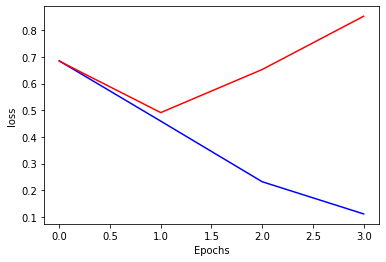

In [156]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

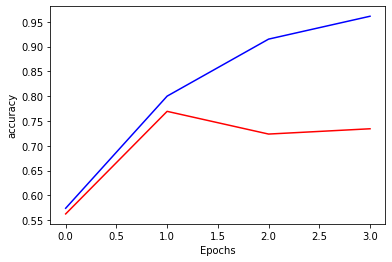

In [157]:
# Visualization of accuracy training 
plt.plot(history.history["accuracy"], color="b")
plt.plot(history.history["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

### Prevision sur le fichier test

In [158]:
# pad sequences
padded_df_test_text_encoded = tf.keras.preprocessing.sequence.pad_sequences(preprocessed_df_test["text_encoded"], padding="post")
padded_df_test_text_encoded


array([[ 128, 1140,   38, ...,    0,    0,    0],
       [  96,  177, 1017, ...,    0,    0,    0],
       [  81,    2,  534, ...,    0,    0,    0],
       ...,
       [ 527,  314,  373, ...,    0,    0,    0],
       [3429,  166,  316, ...,    0,    0,    0],
       [  74,  199,  976, ...,    0,    0,    0]], dtype=int32)

In [159]:
len(padded_df_test_text_encoded)

3263

In [160]:
# predictions du model
result = restored_model.predict(padded_df_test_text_encoded)

In [161]:
result.shape

(3263, 1)

In [162]:
print(result)
print(np.mean(result))

[[0.07886687]
 [0.47096837]
 [0.73672473]
 ...
 [0.9939663 ]
 [0.9586011 ]
 [0.98914903]]
0.3806091


In [163]:
df_submission = pd.read_csv("sample_submission.csv")
print(df_submission.shape)
display(df_submission.head())
df_submission["target"] = result
df_submission["target"] = df_submission["target"].apply(lambda x: 1 if x>0.5 else 0)
display(df_submission.describe())
df_submission.to_csv("test_submission.csv",index=False)

(3263, 2)


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.364695
std,3146.427221,0.481418
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


#### Neural Network with pretrained embedding using tensorflow hub
    this time we won't do any special preprocessing, this will be include in the pretrained layer

In [164]:
df.head()

,id,text,target,text_cleaned,text_tokenized,nlp_ready,text_encoded
0,1,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this # earthquake...,"[deed, Reason, earthquake, ALLAH, forgive]",deed reason earthquake allah forgive,"[4568, 379, 177, 1616, 1976]"
1,4,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask . Canada,"[forest, fire, near, La, Ronge, Sask, Canada]",forest fire near la ronge sask canada,"[81, 2, 151, 662, 6717, 6718, 939]"
2,5,All residents asked to 'shelter in place' are ...,1,All residents asked to ' shelter in place ' ...,"[resident, ask, shelter, place, notify, office...",resident ask shelter place notify officer evac...,"[1133, 397, 1484, 380, 6719, 285, 201, 1484, 3..."
3,6,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive # wildfires evacuation ...","[people, receive, wildfire, evacuation, order,...",people receive wildfire evacuation order calif...,"[5, 1485, 73, 201, 250, 36]"
4,7,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby # Alaska a...,"[send, photo, Ruby, Alaska, smoke, wildfire, p...",send photo ruby alaska smoke wildfire pour school,"[178, 114, 4569, 1486, 172, 73, 2537, 124]"


In [165]:
data = df.iloc[:,1]
print(data)
target = df.iloc[:,2]
print(target)

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7604    #WorldNews Fallen powerlines on G:link tram: U...
7605    on the flip side I'm at Walmart and there is a...
7606    Suicide bomber kills 15 in Saudi security site...
7608    Two giant cranes holding a bridge collapse int...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7503, dtype: object
0       1
1       1
2       1
3       1
4       1
       ..
7604    1
7605    1
7606    1
7608    1
7612    1
Name: target, Length: 7503, dtype: int64


In [166]:
dataset = tf.data.Dataset.from_tensor_slices((data.values, target.values))

In [167]:
# Train Test Split
TAKE_SIZE = 5329

train_data = dataset.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(512)

test_data = dataset.skip(TAKE_SIZE)
test_data = test_data.batch(512)

In [168]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training/cp-{epoch:04d}.ckpt" # the path where checkpoint files
# will be stored

# Create a callback that saves the model's weights every epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=True,
    save_freq=1*len(train_data))

# Token based text embedding trained on English Google News 130GB corpus.
# doc on https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 20)                400020    
_________________________________________________________________
dense_32 (Dense)             (None, 16)                336       
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


In [169]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [170]:
history = model.fit(
    train_data,
    callbacks=[cp_callback],
    validation_data=test_data,
    epochs=20)

Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 0.7269 - accuracy: 0.5307
Epoch 00001: saving model to training/cp-0001.ckpt
11/11 [==============================] - 1s 36ms/step - loss: 0.7269 - accuracy: 0.5307 - val_loss: 0.6828 - val_accuracy: 0.5800
Epoch 2/20
 6/11 [===============>..............] - ETA: 0s - loss: 0.6879 - accuracy: 0.5745
Epoch 00002: saving model to training/cp-0002.ckpt
11/11 [==============================] - 0s 20ms/step - loss: 0.6791 - accuracy: 0.5832 - val_loss: 0.6474 - val_accuracy: 0.6132
Epoch 3/20
 9/11 [=======================>......] - ETA: 0s - loss: 0.6420 - accuracy: 0.6224
Epoch 00003: saving model to training/cp-0003.ckpt
11/11 [==============================] - 0s 23ms/step - loss: 0.6430 - accuracy: 0.6230 - val_loss: 0.6203 - val_accuracy: 0.6559
Epoch 4/20
11/11 [==============================] - ETA: 0s - loss: 0.6146 - accuracy: 0.6750
Epoch 00004: saving model to training/cp-0004.ckpt
11/11 [=======================

In [171]:
model.save("model_pretrained.h17")

INFO:tensorflow:Assets written to: model_pretrained.h17/assets


INFO:tensorflow:Assets written to: model_pretrained.h17/assets


In [172]:
restored_model = tf.keras.models.load_model("/content/model_pretrained.h17")
restored_model.evaluate(test_data)

5/5 [==============================] - 0s 7ms/step - loss: 0.4912 - accuracy: 0.7714


[0.4912150800228119, 0.7713891267776489]

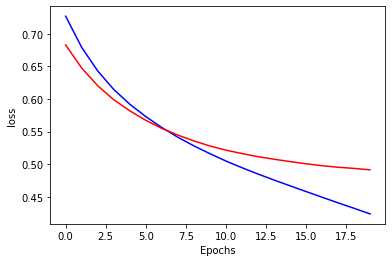

In [173]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

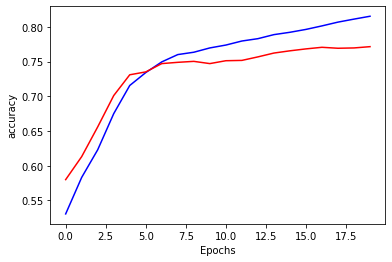

In [174]:
# Visualization of accuracy training 
plt.plot(history.history["accuracy"], color="b")
plt.plot(history.history["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

In [175]:
df_test.head()

,id,text,text_cleaned,text_tokenized,nlp_ready,text_encoded
0,0,Just happened a terrible car crash,Just happened a terrible car crash,"[happen, terrible, car, crash]",happen terrible car crash,"[128, 1140, 38, 11]"
1,2,"Heard about #earthquake is different cities, s...","Heard about # earthquake is different cities,...","[hear, earthquake, different, city, stay, safe]",hear earthquake different city stay safe,"[96, 177, 1017, 74, 357, 873]"
2,3,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese are...","[forest, fire, spot, pond, geese, flee, street...",forest fire spot pond geese flee street save,"[81, 2, 534, 1971, 14461, 2329, 323, 117]"
3,9,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting . # Spokane # wildfires,"[Apocalypse, lighting, , spokane, wildfire]",apocalypse lighting spokane wildfire,"[354, 3254, 4686, 73]"
4,11,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan,"[Typhoon, Soudelor, kill, 28, China, Taiwan]",typhoon soudelor kill 28 china taiwan,"[150, 494, 7, 3539, 224, 972]"


In [176]:
test = df_test.iloc[:,1]
test_dataset = tf.data.Dataset.from_tensor_slices((test.values))

In [178]:
# predictions du model
result = restored_model.predict(test)
for name, value in zip(model.metrics_names, result):
  print("%s: %.3f" % (name, value))

loss: 0.751
accuracy: 0.621


In [179]:
df_submission = pd.read_csv("sample_submission.csv")
print(df_submission.shape)
display(df_submission.head())
df_submission["target"] = result
df_submission["target"] = df_submission["target"].apply(lambda x: 1 if x>0.5 else 0)
display(df_submission.describe())
df_submission.to_csv("test_submission_2.csv",index=False)

(3263, 2)


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.369292
std,3146.427221,0.482687
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


### Conclusions

    After sending the results to the kaggle web site to check the quality of the predictions we can confirm that we produced better score than the baseline score. The kaggle competition use F1 score: we achieved 0.747 with the network with GRU and embedding and 76.0 with the pretrained embedding layer.